# Real-Time CNN Susceptibility Artifact Detection
Using nnU-Net trained model.

## Blobs detection
Inference images (never before seen data)

NVIDIA GeForce RTX 3090
Prediction done, transferring to CPU if needed
Prediction: 0.3580000400543213 seconds
Prediction done, transferring to CPU if needed
Prediction: 0.3679986000061035 seconds


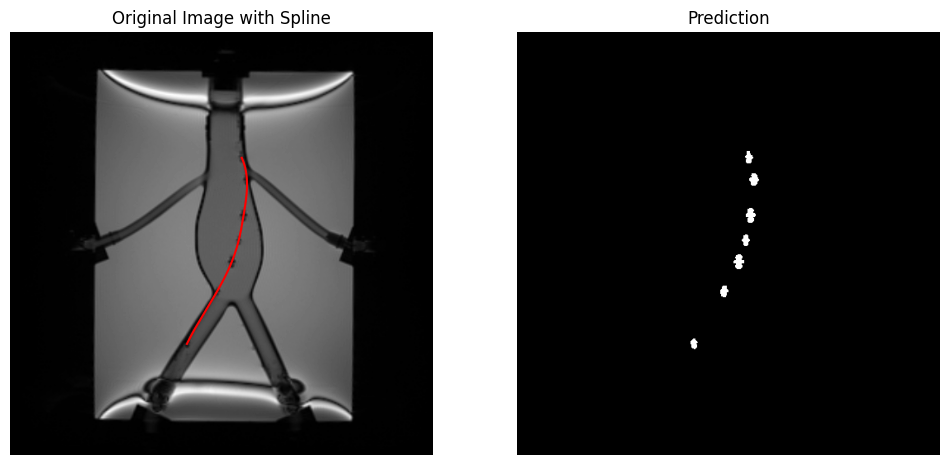

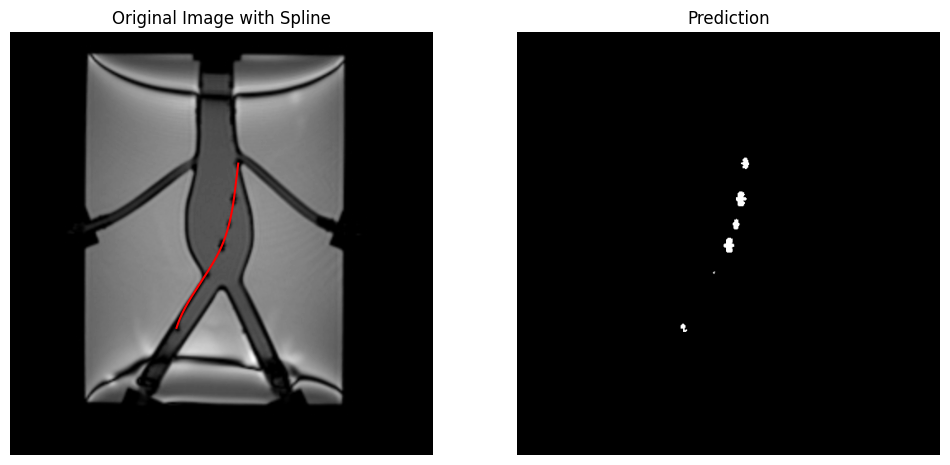

In [13]:
"""
https://github.com/MIC-DKFZ/nnUNet/blob/master/nnunetv2/inference/examples.py
"""
%matplotlib inline
from skimage import measure
import torch
from nnunetv2.inference.predict_from_raw_data import nnUNetPredictor
import cv2
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

if __name__ == '__main__':
    # instantiate the nnUNetPredictor
    predictor = nnUNetPredictor(
        tile_step_size=1,
        use_gaussian=True,
        use_mirroring=True,
        perform_everything_on_gpu=True,
        device=torch.device('cuda', 0),
        verbose=False,
        verbose_preprocessing=False,
        allow_tqdm=False
    )
    
    print(torch.cuda.get_device_name(0))
    
    predictor.initialize_from_trained_model_folder("MODEL", checkpoint_name='checkpoint_final.pth', use_folds=(4,))
    # while True:
    for test_image in os.listdir("MODEL/test-images"):
        image = cv2.imread(os.path.join("MODEL/test-images", test_image), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (512, 512)).astype(np.float32) / 255.0
        cnn_input = image.reshape(1, 1, image.shape[0], image.shape[1])
        props = {'spacing': (999, 1, 1)}
        
        start_time = time.time()
        output = predictor.predict_single_npy_array(cnn_input, props, None, None, True)[0]
        print("Prediction: %s seconds" % (time.time() - start_time))
        
        output_display = (output * 255).astype(np.uint8).reshape(512, 512)
        image_display = (image * 255).astype(np.uint8)
        
        labels = measure.label(output_display > 128)  # Threshold adjusted as needed
        properties = measure.regionprops(labels)
        centers = np.array([prop.centroid for prop in properties])
        
        if len(centers) > 1:
            tck, _ = splprep(centers.T, s=0)
            spline_points = splev(np.linspace(0, 1, 1000), tck)
        
        # Using Matplotlib to display the images
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image_display, cmap='gray')
        plt.plot(spline_points[1], spline_points[0], 'r-')
        plt.title("Original Image with Spline")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(output_display, cmap='gray')
        plt.title("Prediction")
        plt.axis('off')
    plt.show()
    